In [ ]:
#!pip3  uninstall segmentation_models_pytorch
!pip3  install segmentation_models_pytorch

In [1]:
import segmentation_models_pytorch as smp
#hide
#!pip install -q git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
from pathlib import Path
import random
from typing import Any, Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import io, transforms
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
import torch.optim as optim


%matplotlib inline

In [ ]:
torch.optim.

In [2]:
ROOT_PATH = Path("../coco_unet_segmentation/coco_dataset/")
BATCH_SIZE = 4
IMAGE_SIZE = (128, 128)
#  ../coco_unet_segmentation/coco_dataset/

In [3]:
train_annotations = COCO(ROOT_PATH / "annotations/instances_train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/instances_val2017.json")

cat_ids = train_annotations.getCatIds(supNms=["person", "vehicle"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=10.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Number of training images: 74152
Number of validation images: 3125


In [4]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        
        if self.transform is not None:
            return self.transform(img, mask)
        
        return img, mask

In [5]:
def train_transform(
    img1: torch.LongTensor, 
    img2: torch.LongTensor
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    
    # Random horizontal flipping
    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
        
    return img1, img2


In [6]:
train_data = ImageData(train_annotations, train_img_ids, cat_ids, ROOT_PATH / "images/train2017", train_transform)
valid_data = ImageData(valid_annotations, valid_img_ids, cat_ids, ROOT_PATH / "images/val2017", train_transform)

train_dl = DataLoader(
    train_data,
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
)

valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
)

In [ ]:
train_data.

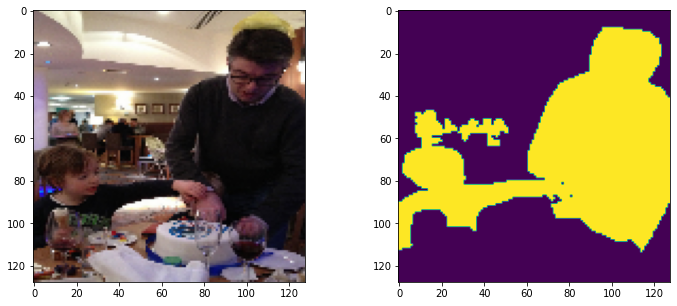

In [7]:
img, mask = train_data[22]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

In [8]:
from torch import nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv64 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv128 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv256 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv512 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv1024 = nn.Conv2d(512, 1024, 3, padding=1)
        self.upconv1024 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dconv1024 = nn.Conv2d(1024, 512, 3, padding=1)
        self.upconv512 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dconv512 = nn.Conv2d(512, 256, 3, padding=1)
        self.upconv256 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dconv256 = nn.Conv2d(256, 128, 3, padding=1)
        self.upconv128 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dconv128 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv1 = nn.Conv2d(64, 183, 1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x1 = F.relu(self.conv64(x / 255.))
        x2 = F.relu(self.conv128(self.pool(x1)))
        x3 = F.relu(self.conv256(self.pool(x2)))
        x4 = F.relu(self.conv512(self.pool(x3)))
        x5 = F.relu(self.conv1024(self.pool(x4)))
        ux5 = self.upconv1024(x5)
        cc5 = torch.cat([ux5, x4], 1)
        dx4 = F.relu(self.dconv1024(cc5))
        ux4 = self.upconv512(dx4)
        cc4 = torch.cat([ux4, x3], 1)
        dx3 = F.relu(self.dconv512(cc4))
        ux3 = self.upconv256(dx3)
        cc3 = torch.cat([ux3, x2], 1)
        dx2 = F.relu(self.dconv256(cc3))
        ux2 = self.upconv128(dx2)
        cc2 = torch.cat([ux2, x1], 1)
        dx1 = F.relu(self.dconv128(cc2))  # no relu?
        last = self.conv1(dx1)
        return last  # sigmoid if classes arent mutually exclusv


In [36]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
device

device(type='cuda')

In [37]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 1, 128, 128]))

In [38]:
criterion = nn.CrossEntropyLoss()
#nn.BCEWithLogitsLoss()

In [13]:
outputs.shape

NameError: name 'outputs' is not defined

In [ ]:
labels.shape

In [ ]:
#outputs = model(inputs)
criterion(outputs, labels.reshape(64, 128, 128))

In [39]:
n_iter = 2
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape(-1, 128, 128))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_iter == n_iter-1 :    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n_iter:.3f}')
            running_loss = 0.0
        if i > 300:
            break
print('Finished Training')

[1,     2] loss: 5.196
[1,     4] loss: 5.181
[1,     6] loss: 5.155
[1,     8] loss: 5.146
[1,    10] loss: 5.098
[1,    12] loss: 5.096
[1,    14] loss: 5.029
[1,    16] loss: 4.922
[1,    18] loss: 4.942
[1,    20] loss: 4.873
[1,    22] loss: 4.821
[1,    24] loss: 4.767
[1,    26] loss: 4.698
[1,    28] loss: 4.648
[1,    30] loss: 4.461
[1,    32] loss: 4.470
[1,    34] loss: 4.345
[1,    36] loss: 4.189
[1,    38] loss: 4.073
[1,    40] loss: 3.837
[1,    42] loss: 3.446
[1,    44] loss: 3.209
[1,    46] loss: 2.970
[1,    48] loss: 2.694
[1,    50] loss: 1.970
[1,    52] loss: 2.302
[1,    54] loss: 2.148
[1,    56] loss: 2.433
[1,    58] loss: 1.776
[1,    60] loss: 1.473
[1,    62] loss: 1.380
[1,    64] loss: 1.841
[1,    66] loss: 1.118
[1,    68] loss: 1.275
[1,    70] loss: 1.847
[1,    72] loss: 1.507
[1,    74] loss: 1.499
[1,    76] loss: 2.337
[1,    78] loss: 1.633
[1,    80] loss: 1.953
[1,    82] loss: 0.634
[1,    84] loss: 1.665
[1,    86] loss: 0.960
[1,    88] 

In [29]:
!pip install albumentations

In [34]:

import albumentations as A
from albumentations.pytorch import ToTensorV2

inference_transform = A.Compose([
    A.Resize(400, 400, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

def predict(model, img):
    model.eval()
    with torch.no_grad():
        images = img
        output = model(images)
        predicted_masks = (output.squeeze() >= 0.5).float().cpu().numpy()
        
    return(predicted_masks)

#define function to load image and output mask
def get_mask(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = tuple(image.shape[:2])
    
    image_trans = inference_transform(image = image)
    image_trans = image_trans["image"]
    image_trans = image_trans.unsqueeze(0)
    model = torch.load('models/entire_model_8.pt')
    model.eval()
    image_mask = predict(model, image_trans)
    image_mask = F.resize(image_mask, original_height, original_width, 
                           interpolation=cv2.INTER_NEAREST)
        
    return(image_mask)

In [40]:
import cv2
model.eval()
example_path = "1.jpg"
image = cv2.imread(example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = get_mask(example_path)

masked_img = image*np.expand_dims(mask, 2).astype("uint8")

#plot the image, mask and multiplied together
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(masked_img)
plt.plot()

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor